<a href="https://colab.research.google.com/github/TAMIDSpiyalong/Introduction-to-Machine-Learning-for-Energy/blob/main/Lecture_3a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab: YOLO for Construction Personal-Protective-Equipment (PPE)

To improve safety compliance in the construction industry, we have developed three innovative deep learning models based on the You-Only-Look-Once (YOLO) architecture, which is an extremely fast accurate object detection. These models enable real-time verification of PPE usage by construction workers from image and video data.

## Objectives

1. Build a YOLO model from scratch and study it structure
2. Understand the output of FPN and anchor boxes
3. Visualize the output and post-processing techniques

## Download dataset

This dataset contains 784 images taken by Yalong Pi from construction sites in Zhuhai Gree Real Estate Company. The annotation is prepared by Yalong Pi and Nipun Nath. You might find them in the dataset. More details can be found in this paper https://www.sciencedirect.com/science/article/pii/S0926580519308325. This dataset is loaded in three different ways but we are going to look at approach 1 for the purpose of this lab.

In [ ]:
import gdown
gdown.download('https://drive.google.com/uc?export=download&id=1zaVc5rMikV_xrKJj1YzlKxs4vGdQu-Nv')
gdown.download('https://drive.google.com/uc?export=download&id=19hynq93etP5xDdkmOMWnOPPccWroMxqR')

! unzip -q pictor-ppe.zip
# https://drive.google.com/file/d/1zaVc5rMikV_xrKJj1YzlKxs4vGdQu-Nv/view?usp=drive_link
# https://drive.google.com/file/d/19hynq93etP5xDdkmOMWnOPPccWroMxqR/view?usp=drive_link

Downloading...
From: https://drive.google.com/uc?export=download&id=1zaVc5rMikV_xrKJj1YzlKxs4vGdQu-Nv
To: /content/pictor-ppe-v302-a1-yolo-v3-weights.h5
100%|██████████| 247M/247M [00:06<00:00, 38.3MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=19hynq93etP5xDdkmOMWnOPPccWroMxqR
To: /content/pictor-ppe.zip
100%|██████████| 368M/368M [00:07<00:00, 52.4MB/s]


## Build YOLO from scratch

First, let's import the necessary packages we need.

In [ ]:
import numpy as np
import cv2

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Input, Conv2D, Add, ZeroPadding2D, UpSampling2D, Concatenate, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model, model_to_dot

The yolo_ConvBlock function we provided defines a convolutional block for a YOLO-like neural network. This block is a fundamental building block often used in YOLO models and similar architectures for object detection and image classification tasks. Let's break down the function and its components:

'input_tensor': This is the input tensor to the convolutional block. It represents the feature map or image that you want to process.

'num_filters': The number of filters (also known as output channels) in the convolutional layer. Each filter learns to detect a specific feature in the input data.

'filter_size': The size of the convolutional filters. It is typically specified as a tuple (height, width).

'strides': The stride of the convolution operation. It is a tuple (vertical_stride, horizontal_stride) that determines the step size of the filter as it moves across the input tensor. If strides is (2, 2), the padding is set to 'valid' to reduce the feature map size.

In [ ]:
def yolo_ConvBlock (input_tensor, num_filters, filter_size, strides = (1,1) ):
    padding = 'valid' if strides == (2,2) else 'same'

    '''Layers'''
    x = Conv2D( num_filters, filter_size, strides, padding, use_bias=False, kernel_regularizer=l2(5e-4) ) (input_tensor)
    x = BatchNormalization() (x)
    x = LeakyReLU(alpha=0.1) (x)

    return x

YOLO v3 also use the ResNet identify block. The yolo_ResidualBlocks function we provided defines a series of residual blocks, a type of architecture commonly used in deep convolutional neural networks to improve gradient flow and enable the training of very deep networks. Residual blocks help mitigate the vanishing gradient problem and facilitate training of deeper models. Let's break down the function and its components:

'input_tensor': This is the input tensor to the residual blocks. It represents the feature map or image that you want to process.

'num_filters': The number of filters (output channels) used in the convolutional layers within the residual blocks.

'num_blocks': The number of residual blocks to create in the architecture.

The yolo_ResidualBlocks function constructs a stack of residual blocks, which can be added to a neural network architecture to create a deeper and more expressive model. Residual blocks are a fundamental concept in modern deep learning architectures, enhancing the training and performance of deep neural networks.

In [ ]:
def yolo_ResidualBlocks (input_tensor, num_filters, num_blocks ):

    '''Layers'''
    x = ZeroPadding2D( ((1,0),(1,0)) ) (input_tensor) # left & top padding
    x = yolo_ConvBlock ( x, num_filters, filter_size=(3,3), strides = (2,2) )
    for _ in range( num_blocks ):
        y = yolo_ConvBlock ( x, num_filters//2, filter_size=(1,1), strides = (1,1) )
        y = yolo_ConvBlock ( y, num_filters   , filter_size=(3,3), strides = (1,1) )
        x = Add() ([x, y])

    return x

This OutputBlock provides the features and also passes down and info to the next layer. This block is responsible for producing the final predictions of bounding boxes and object classes for the YOLO object detection model  

In [ ]:
def yolo_OutputBlock (x, num_filters, out_filters ):

    '''Layers'''
    x = yolo_ConvBlock ( x, 1*num_filters, filter_size=(1,1), strides = (1,1) )
    x = yolo_ConvBlock ( x, 2*num_filters, filter_size=(3,3), strides = (1,1) )
    x = yolo_ConvBlock ( x, 1*num_filters, filter_size=(1,1), strides = (1,1) )
    x = yolo_ConvBlock ( x, 2*num_filters, filter_size=(3,3), strides = (1,1) )
    x = yolo_ConvBlock ( x, 1*num_filters, filter_size=(1,1), strides = (1,1) )

    y = yolo_ConvBlock ( x, 2*num_filters, filter_size=(3,3), strides = (1,1) )
    y = Conv2D ( filters=out_filters, kernel_size=(1,1), strides=(1,1),
                padding='same', use_bias=True, kernel_regularizer=l2(5e-4) )(y)

    return x, y

We put everything together and the output will be y1, y2, and y3. Each of them has the num_out_filters equal the numer of classes.

In [ ]:
def yolo_body (input_tensor, num_out_filters):
    '''
    Input:
        input_tensor   = Input( shape=( *input_shape, 3 ) )
        num_out_filter = ( num_anchors // 3 ) * ( 5 + num_classes )
    Output:
        complete YOLO-v3 model
    '''

    # 1st Conv block
    x = yolo_ConvBlock( input_tensor, num_filters=32, filter_size=(3,3), strides=(1,1) )

    # 5 Resblocks
    x = yolo_ResidualBlocks ( x, num_filters=  64, num_blocks=1 )
    x = yolo_ResidualBlocks ( x, num_filters= 128, num_blocks=2 )
    x = yolo_ResidualBlocks ( x, num_filters= 256, num_blocks=8 )
    x = yolo_ResidualBlocks ( x, num_filters= 512, num_blocks=8 )
    x = yolo_ResidualBlocks ( x, num_filters=1024, num_blocks=4 )

    darknet = Model( input_tensor, x ) # will use it just in a moment

    # 1st output block
    x, y1 = yolo_OutputBlock( x, num_filters= 512, out_filters=num_out_filters )

    # 2nd output block
    x = yolo_ConvBlock( x, num_filters=256, filter_size=(1,1), strides=(1,1) )
    x = UpSampling2D(2) (x)
    x = Concatenate() ( [x, darknet.layers[152].output] )
    x, y2 = yolo_OutputBlock( x, num_filters= 256, out_filters=num_out_filters )

    # 3rd output block
    x = yolo_ConvBlock( x, num_filters=128, filter_size=(1,1), strides=(1,1) )
    x = UpSampling2D(2) (x)
    x = Concatenate() ( [x, darknet.layers[92].output] )
    x, y3 = yolo_OutputBlock( x, num_filters= 128, out_filters=num_out_filters )

    # Final model
    model = Model( input_tensor, [y1, y2, y3] )

    return model

### Configuaration

In this lab, we modify the YOLO model to detect three classes of objects of interests: hardhat, vest, and worker. The anchor boxes are learned from the image annotation.

In [ ]:
class_names = ['Hardhat', 'Vest', 'Worker']

anchor_boxes = np.array(
        [
        np.array([[ 76,  59], [ 84, 136], [188, 225]]) /32, # output-1 anchor boxes
        np.array([[ 25,  15], [ 46,  29], [ 27,  56]]) /16, # output-2 anchor boxes
        np.array([[ 5,    3], [ 10,   8], [ 12,  26]]) /8   # output-3 anchor boxes
        ],
        dtype='float64'
    )

input_shape  = (416, 416)

### Model

We build the model and load the pretrained weights. Keras has a nice tool to see the structure. Try to find the y1, y2, and y3 output in the visualization.

In [ ]:
K.clear_session() # clear memory

# number of classes and number of anchors
num_classes = 3
num_anchors = anchor_boxes.shape[0] * anchor_boxes.shape[1]

# input and output
input_tensor = Input( shape=(input_shape[0], input_shape[1], 3) ) # input
num_out_filters = ( num_anchors//3 ) * ( 5 + num_classes )        # output

# build the model
model = yolo_body(input_tensor, num_out_filters)

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Load weights

In [ ]:
weight_path = 'pictor-ppe-v302-a1-yolo-v3-weights.h5'

model.load_weights( weight_path )

## Pre-processing Image

The purpose of the letterbox function is to resize an input image while preserving its aspect ratio. The technique achieves this by adding padding (usually in the form of black bars) to the image so that it fits into a fixed-size canvas without distortion. The resulting image has the same aspect ratio as the original, but it is centered within the fixed-size canvas.


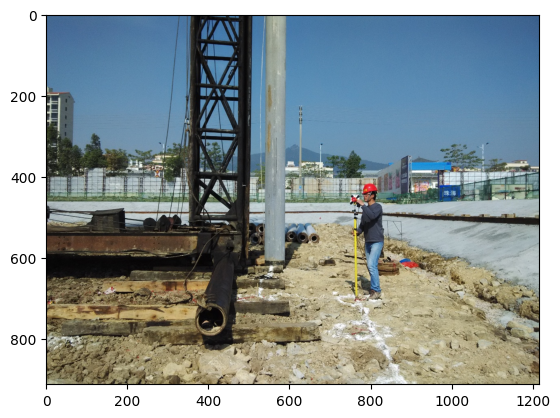

In [ ]:
def letterbox_image(image, size):
    '''
    Resize image with unchanged aspect ratio using padding
    '''

    # original image size
    ih, iw, ic = image.shape

    # given size
    h, w = size

    # scale and new size of the image
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)

    # placeholder letter box
    new_image = np.zeros((h, w, ic), dtype='uint8') + 128

    # top-left corner
    top, left = (h - nh)//2, (w - nw)//2

    # paste the scaled image in the placeholder anchoring at the top-left corner
    new_image[top:top+nh, left:left+nw, :] = cv2.resize(image, (nw, nh))

    return new_image

import matplotlib.pyplot as plt
import matplotlib as mpl

act_img = cv2.imread('Images/image_from_china(2685).jpg')
image_shape = act_img.shape[:-1]
img = letterbox_image(act_img, (416,416))/255.
img = np.expand_dims(img, 0)

'''Show the image'''
plt.imshow( act_img[:,:,::-1] )
# plt.axis('off')
plt.show()

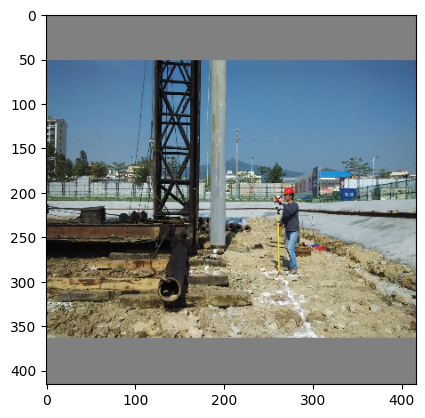

In [ ]:
'''Show the letterbox image'''
plt.imshow( letterbox_image(act_img, (416,416))[:,:,::-1] )
# plt.axis('off')
plt.show()

## Get prediction

In [ ]:
yolo_pred = model.predict(img)

1/1 [==============================] - 9s 9s/step


## Understand the Output

### Analyze the predicted values

- The predictions in each output layer is a 4-dimensional tensor with a shape of:  
( batch size, # of grids in x-dir, # of grids in y-dir, # anchor boxes in this layer * ( 5 + # of classes ) )

In [ ]:
for i in range( len(yolo_pred) ):
    print('Output-y{} shape: '.format(i+1), yolo_pred[i].shape )

Output-y1 shape:  (1, 13, 13, 24)
Output-y2 shape:  (1, 26, 26, 24)
Output-y3 shape:  (1, 52, 52, 24)


- Let's reshape it to a 5-dimensional tensor with a shape of:  
( batch size, # of grids in x-dir, # of grids in y-dir, # of anchor boxes in this layer,  ( 5 + # of classes ) )

In [ ]:
pred = []
for i in range( len(yolo_pred) ):
    pred.append( yolo_pred[i].reshape( [-1, *yolo_pred[i].shape[1:3], 3, (5+num_classes) ] ) )

for i in range( len(yolo_pred) ):
    print('Output y{} shape: '.format(i+1), pred[i].shape )

Output y1 shape:  (1, 13, 13, 3, 8)
Output y2 shape:  (1, 26, 26, 3, 8)
Output y3 shape:  (1, 52, 52, 3, 8)


- Let's find which grid in the $1^{st}$ output layer has the highest probability of presence of an object (a.k.a. objectness score)

In [ ]:
yolo_pred[0].shape

(1, 13, 13, 24)

In [ ]:
grid_shape = pred[0].shape[1:3] # shape of the grids

obj_scores = pred[0] [0, :, :, :, 4] # objectness scores
grid_i, grid_j, abox_k = np.unravel_index( np.argmax( obj_scores, axis=None ), obj_scores.shape )

abox = anchor_boxes[0][abox_k] # corresponding anchor box

print( "Grid size: ({}, {})".format( *grid_shape ) )
print( "Most likely there is an object in grid ({}, {}) with anchor box of size {}".format( grid_i, grid_j, abox ) )

Grid size: (13, 13)
Most likely there is an object in grid (7, 8) with anchor box of size [2.375   1.84375]


We can see the object score  for each anchor box. At this point, all the numbers are raw values.

<Axes: >

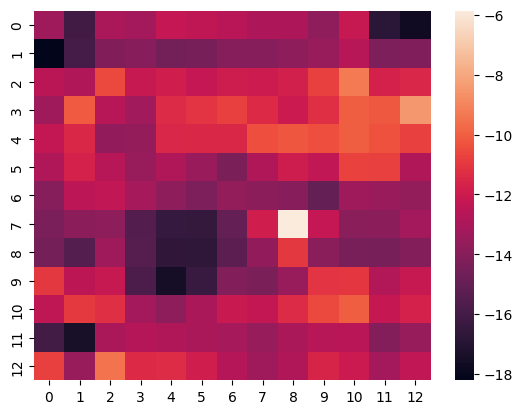

In [ ]:
import seaborn as sns
sns.heatmap(obj_scores[:,:,0])

- Predicted raw values in one grid for one bounding box: ( $t_x$, $t_y$, $t_w$, $t_h$, $t_{p_0}$, $t_{p_1}$, ..., $t_{p_n}$ )

In [ ]:
np.set_printoptions( precision=4 )

print( 'box parameters (x, y) : {}'.format( pred [0] [0, grid_i, grid_j, abox_k, 0:2] ) )
print( 'box parameters (w, h) : {}'.format( pred [0] [0, grid_i, grid_j, abox_k, 2:4] ) )
print( 'objectness score      : {}'.format( pred [0] [0, grid_i, grid_j, abox_k, 4:5] ) )
print( 'class probabilities   : {}'.format( pred [0] [0, grid_i, grid_j, abox_k, 5:5+num_classes] ) )

box parameters (x, y) : [4.0951e-04 7.9392e-01]
box parameters (w, h) : [-0.7088  0.6368]
objectness score      : [-5.8618]
class probabilities   : [-8.2161 -9.4031  8.7309]


- Transformed values in one grid for one bounding box: ( $x$, $y$, $w$, $h$, $p_0$, $p_1$, ..., $p_n$ )  
- Coordinates of the center of the box: x, y = sigmoid($t_x$), sigmoid($t_y$)  
- Width and height of the box: w, h = exp($t_w$), exp($t_h$)  
- Objectness score: $p_0$ =  sigmoid($t_{p_0}$)  
- Class probabilities: $p_i$ =  sigmoid($t_{p_i}$) for $i$ = 1, ..., n

In [ ]:
np.set_printoptions( precision=2, suppress=True )

# define the sigmoid function
sigmoid = lambda x : 1 / ( 1 + np.exp(-x) )

bx_xy     = sigmoid( pred [0] [0, grid_i, grid_j, abox_k, 0:2] ) # box's center (x and y)
bx_wh     = np.exp ( pred [0] [0, grid_i, grid_j, abox_k, 2:4] ) # box's width and height
obj_score = sigmoid( pred [0] [0, grid_i, grid_j, abox_k, 4:5] ) # objectness score
cls_probs = sigmoid( pred [0] [0, grid_i, grid_j, abox_k, 5:5+num_classes] ) # conditional class probabilities

print( 'box parameters (x, y) : {}'.format( bx_xy ) )
print( 'box parameters (w, h) : {}'.format( bx_wh ) )
print( 'objectness score      : {}'.format( obj_score ) )
print( 'class probabilities   : {}'.format( cls_probs ) )

box parameters (x, y) : [0.5  0.69]
box parameters (w, h) : [0.49 1.89]
objectness score      : [0.]
class probabilities   : [0. 0. 1.]


### Interpretation of the box parameters (center)
- each grid cell's width and height is assumed to be 1.
- origin of the coordinate system is top-left corner.
- let the index of the cell is ($i$, $j$), i.e., the cell is at $i^{th}$ row from top and at $j^{th}$ column from left.
- box parameter (x, y) indicates the offset of the box's center from the grid cell's upper-left corner.
- therefore, the box's center measured from origin (top-left) would be: ($j$ + $x$, $i$ + $y$)

center of the box in the 13x13 grid : (8.50, 7.69)


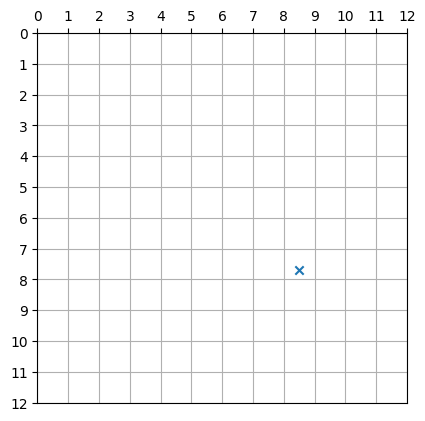

In [ ]:
# grid's index
grid_ji = np.array([grid_j, grid_i], dtype=float)

# center of the box, measured from origin (top-left)
bx_xy_origin = bx_xy + grid_ji

print( 'center of the box in the {0}x{1} grid : ({2:.2f}, {3:.2f})'.format( *pred[0].shape[1:3], *bx_xy_origin ) )

'''Plot the center of the box in the grid'''
plt.figure()
plt.scatter(*bx_xy_origin, marker='x')
plt.xticks(np.arange(obj_scores.shape[1]))
plt.yticks(np.arange(obj_scores.shape[0]))
plt.gca().xaxis.tick_top()
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
ax = plt.gca()
plt.grid()
plt.show()

### Interpretation of the box parameters (width and height)
- Box parameter (w,h) indicates the how much to scale the anchor boxes
- Given, the width and height of anchor boxes be $w_a$ and $h_a$, respectively. The width and height of the detected bounding would be: $w_a*w$ and $h_a*h$, respectively.

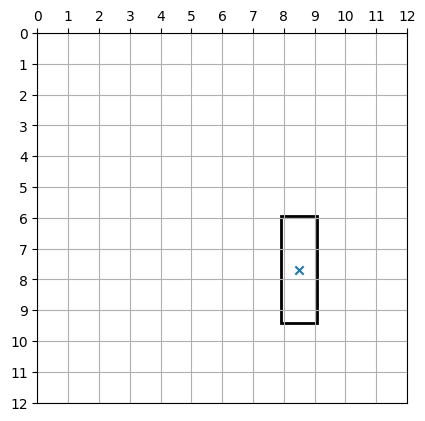

In [ ]:
# bounding box's actual width and height
# (considering each grid cell's size is 1 unit)
bx_wh_origin = bx_wh * abox

'''Plot the bounding box in the grid'''
plt.figure()
plt.scatter(*bx_xy_origin, marker='x')
bx = mpl.patches.Rectangle(bx_xy_origin-bx_wh_origin/2, *bx_wh_origin, fill=False, lw=2)
plt.gca().add_patch(bx)
plt.xticks(np.arange(obj_scores.shape[1]))
plt.yticks(np.arange(obj_scores.shape[0]))
plt.gca().xaxis.tick_top()
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
ax = plt.gca()
plt.grid()
plt.show()

### Interpretation of the objectness score and conditional class probabilities
- Objectness score $p_0$ represents the probability of the presence of an object.
- Given an object present, $p_i$ represents the conditional probability of object belong to class $i$ (for $i$ = 0.9, ..., n).
- In other words, $p_0$ = P( object ), and $p_i$ = P( class = $i$ | object )
- Therefore,  
P( class = $i$ )  
= $$\frac{P( class = i | object ) \times P( object )}{\sum_i P( class = i | object ) \times P( object )}$$
= $$\frac{p_0 \times p_i}{\sum_i (p_0 \times p_i)}$$
- Final class, c = $$\text{argmax}_i \frac{p_0 \times p_i}{\sum_i (p_0 \times p_i)}$$ = $\text{argmax}_i (p_0 \times p_i)$
- $p_0 \times p_i$ is called the confidence score of the box

In [ ]:
cls_id     = np.argmax( obj_score * cls_probs )
conf_score = obj_score * cls_probs[cls_id]

print( 'The predicted class of object inside the box is {}'.format( class_names[cls_id] ) )
print( 'The corresponding confidence score is {}'.format( conf_score[0] ) )

The predicted class of object inside the box is Worker
The corresponding confidence score is 0.002837660489603877


### Rescale the boxes

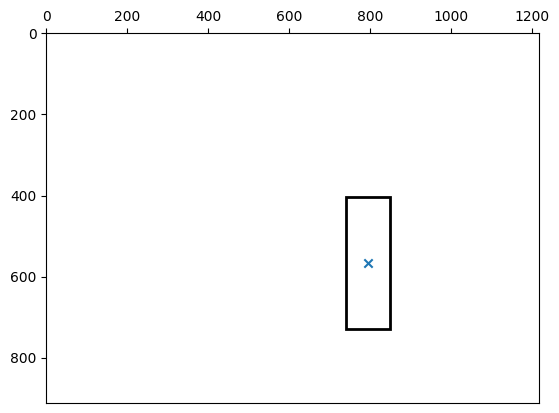

In [ ]:
input_shape = np.array(input_shape).astype('float')
image_shape = np.array(image_shape).astype('float')
grid_shape  = np.array(grid_shape).astype('float')

# the resized new shape of the image
resized_shape = np.round( image_shape * np.min( input_shape / image_shape ) )

bx_offset = (image_shape.max() - image_shape) / 2.
bx_scale  = input_shape * image_shape / resized_shape / grid_shape

bx_xy_on_img = bx_xy_origin * bx_scale[::-1] - bx_offset[::-1]
bx_wh_on_img = bx_wh_origin * bx_scale[::-1]

'''Plot the bounding box in the grid'''
plt.figure()
plt.scatter( *bx_xy_on_img, marker='x' )
bx = mpl.patches.Rectangle( bx_xy_on_img-bx_wh_on_img/2, *bx_wh_on_img, fill=False, lw=2 )
plt.gca().add_patch(bx)
plt.xlim([0, image_shape[1]])
plt.ylim([0, image_shape[0]])
plt.gca().xaxis.tick_top()
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
plt.show()

### Show on image

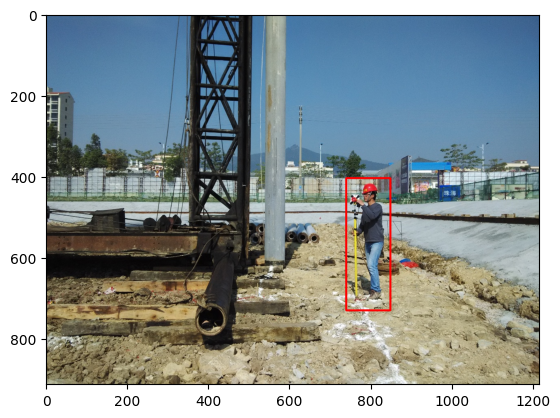

In [ ]:
### Calculate top-left and bottom-right corner of the box
t,l = np.array( bx_xy_on_img - bx_wh_on_img/2 ).astype('int')
b,r = np.array( bx_xy_on_img + bx_wh_on_img/2 ).astype('int')

'''Show the image with the box'''
detected_img = cv2.rectangle(act_img, (t,l), (b,r), (0,0,255), 4)
plt.imshow( detected_img[:,:,::-1] )
# plt.axis('off')
plt.show()

## Get All Boxes
Now let's get all the boxes at the $1^{st}$ output layers.

We will use tensors to calculate properties of the boxes altogether.

In [ ]:
'''Inputs'''
output  = yolo_pred[0]
anchors = anchor_boxes[0]

In [ ]:
'''Some preprocessing'''
grid_h, grid_w = output.shape[1:3] # grid_height, grid_width @ output layer

# reshape to [batch_size, grid_height, grid_width, num_anchors, box_params]
output = tf.reshape( output, [ -1, grid_h, grid_w, len(anchors), num_classes+5 ] )

# create a tensor for the anchor boxes
anchors_tensor = tf.constant(anchors, dtype=output.dtype)
anchors_tensor = tf.reshape( anchors_tensor, [1, 1, 1, len(anchors), 2] )

### **Geometric properties**

In [ ]:
'''Grid positions'''
grid_i = tf.reshape( np.arange(grid_h), [-1, 1, 1, 1] )
grid_i = tf.tile( grid_i, [1, grid_w, 1, 1] )

grid_j = tf.reshape( np.arange(grid_w), [1, -1, 1, 1] )
grid_j = tf.tile( grid_j, [grid_h, 1, 1, 1] )

grid_ji = tf.concat( [grid_j, grid_i], axis=-1 )
grid_ji = tf.cast( grid_ji, output.dtype )

'''Box centers'''
box_xy  = output[..., 0:2]
box_xy  = tf.sigmoid( box_xy ) + grid_ji

'''Box sizes'''
box_wh  = output[..., 2:4]
box_wh  = tf.exp( box_wh ) * anchors_tensor

Let's see how do `grid_j`, `grid_i` and `box_xy` look like:

In [ ]:
print('grid_j is the x-coordinates of the grid cells:\n')
print( grid_j[:,:,0,0].numpy().astype(int) )

print('\ngrid_i is the y-coordinates of the grid cells:\n')
print( grid_i[:,:,0,0].numpy().astype(int) )

np.set_printoptions(precision =2, suppress =True, linewidth=120)

print("\nbox_xy[...,0] is the x-coordinates of the boxes' centers:\n")
print( box_xy[:,:,:,0,0].numpy().astype(float) )

print("\nbox_xy[...,1] is the y-coordinates of the boxes' centers:\n")
print( box_xy[:,:,:,0,1].numpy().astype(float) )

grid_j is the x-coordinates of the grid cells:

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]]

grid_i is the y-coordinates of the grid cells:

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 3  3  3  3  3  3  3  3  3  3  3  3  3]
 [ 4  4  4  4  4  4  4  4  4  4  4  4  4]
 [ 5  5  5  5  5  5  5  5  5  5  5  5  5]
 [ 6  6  6  6  6  6  6  6  6  6  6  6  6]
 [ 7  7  7  7  7  7  7  7  7  7  7  7  7]
 [ 8  8  8  8  8  8 

### **Probabilities**

In [ ]:
'''Class and confidence scores'''
# class probabilities = objectness score * conditional class probabilities
classs_probs = tf.sigmoid( output[..., 4:5] ) * tf.sigmoid( output[..., 5:] )

# final classes
box_cl = tf.argmax( classs_probs, axis=-1 )

# confidence scores
box_sc = tf.reduce_max( classs_probs, axis=-1 )

`box_sc` indicates which cell might contain an object of interest. Let's see how does it look like:

In [ ]:
np.max(box_sc)

0.0028376607

<Axes: >

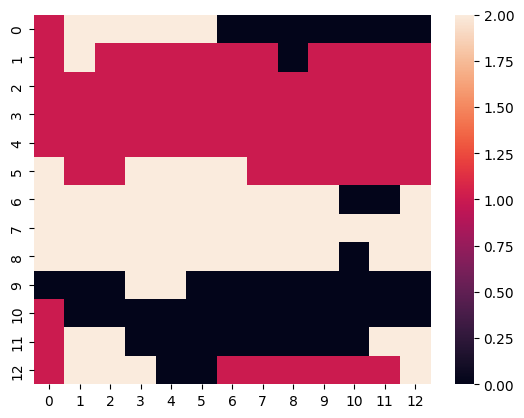

In [ ]:
sns.heatmap(box_cl[0][:,:,0])

<Axes: >

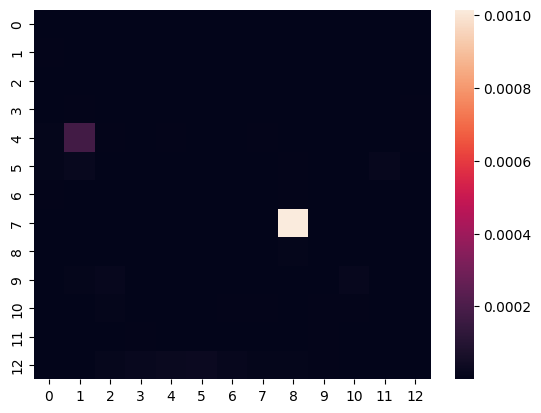

In [ ]:
sns.heatmap(box_sc[0][:,:,1])

<Axes: >

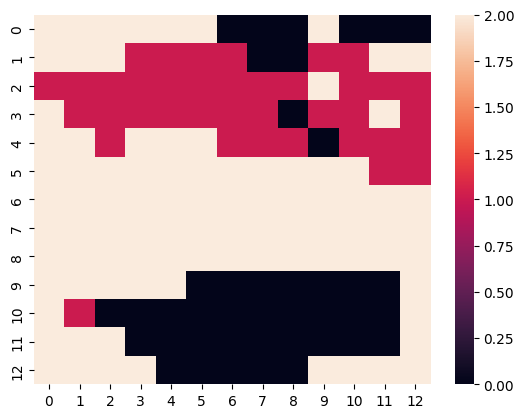

In [ ]:
sns.heatmap(box_cl[0][:,:,1])

<Axes: >

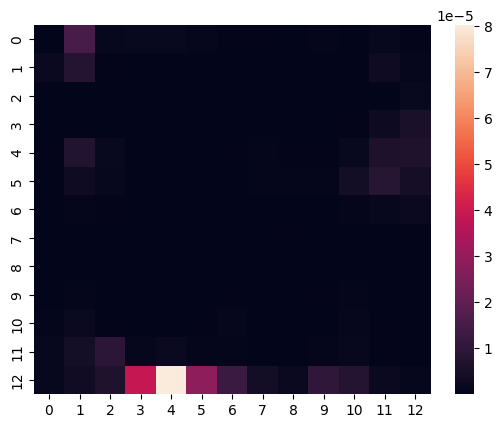

In [ ]:
sns.heatmap(box_sc[0][:,:,2])

<Axes: >

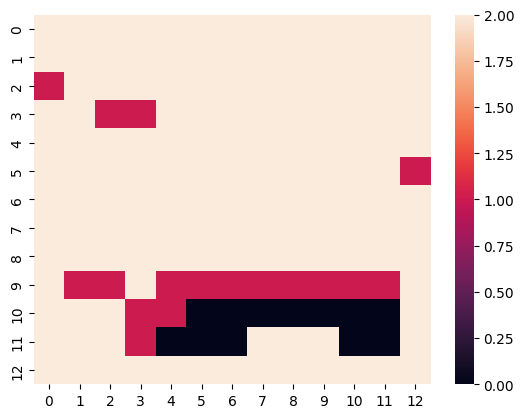

In [ ]:
sns.heatmap(box_cl[0][:,:,2])

### **Rescaling**

Rescaling is very important in customized models. If not properly rescaled back, the output does not make sense. Many pre-trained models does rescaling for you so you do not have to worry about it. In YOLO, rescaling from anchor box offset back to the original size is even more complicated.

In [ ]:
'''Get all the shapes'''
image_shape = tf.cast( image_shape,       output.dtype)  # actual image's shape
input_shape = tf.cast( input_shape,       output.dtype)  # yolo input image's shape
grids_shape = tf.cast( output.shape[1:3], output.dtype ) # grid_height, grid_width @ output layer

# the resized new shape of the image
# i.e. shape after resizing the image to fit 'input shape' without changing the aspect ratio
resized_shape = tf.round( image_shape * np.min( input_shape / image_shape ) )

'''Scaling factors'''
# to scale the boxes from grid's unit to actual image's pixel unit
box_scaling = input_shape * image_shape / resized_shape / grids_shape
# to offset the boxes
box_offsets = (tf.reduce_max(image_shape) - image_shape) / 2.

'''Scale to actual pixel unit'''
box_xy_on_img  = box_xy * box_scaling - box_offsets[::-1]
box_wh_on_img  = box_wh * box_scaling

'''Check boundaries'''
# calculate top-left and bottom-right corner of the boxex
box_tl = box_xy_on_img - box_wh_on_img/2
box_br = box_xy_on_img + box_wh_on_img/2

# top-left corner cannot be negative
box_tl = tf.maximum(0, box_tl)
box_tl = tf.cast( tf.round( box_tl ), dtype='int16' )
# bottom-right corner cannot be more than actual image size
box_br = tf.minimum(box_br, image_shape[::-1])
box_br = tf.cast( tf.round( box_br ), dtype='int16' )

### **Reorganizing**

In [ ]:
boxes  = tf.reshape( tf.concat( [box_tl, box_br], axis=-1 ), [-1,4] )
labels = tf.reshape( box_cl, [-1] )
scores = tf.reshape( box_sc, [-1] )

In [ ]:
boxes.shape

TensorShape([507, 4])

In [ ]:
best_box = boxes[np.argmax(scores)].numpy()

In [ ]:
best_box[0]

740

Show all the positve scored boxes on image and you will see a lot of boxes. Out of all the boxes, there could be more than one high confidence prediction. We visualize the best one to show the results. In reality, we do not know in advance how many objects are there so we use the threshold to filter the low quality detections.

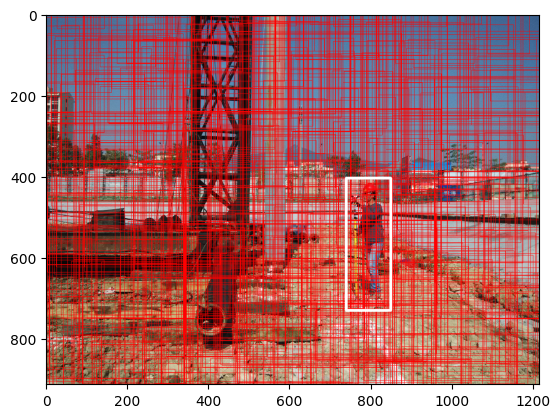

There are a total of 507 boxes in y1! The best box is marked white with confidence of 0.0028376607224345207.


In [ ]:
'''Get the boxes with some non-zero confidence'''
idc = scores > 0 # indices
num_boxes = tf.math.count_nonzero(idc) # number of boxes

'''Put the rectangular boxes on the image'''
act_img = cv2.imread('Images/image_from_china(2685).jpg')

for (t,l,b,r), class_id, conf in zip( boxes [idc].numpy(),
                                      labels[idc].numpy(),
                                      scores[idc].numpy()
                                    ):
    detected_img = cv2.rectangle(act_img, (t,l), (b,r), (0,0,255), 1)

cv2.rectangle(act_img, (best_box[0],best_box[1]), (best_box[2],best_box[3]), (255,255,255), 5)

plt.imshow( detected_img[:,:,::-1] )
# plt.axis('off')
plt.show()

print('There are a total of {} boxes in y1! The best box is marked white with confidence of {}.'.format(num_boxes,np.max(scores)))

### **Non-max-suppression**
Most of the detected boxes are flase positive, reduntant, and/or duplicate of other boxes. To get rid of these boxes and to keep only the most confident boxes, we will use *non-max-suppression* (NMS) algorithm.


For each class:
1. First, get rid of all the boxes with confidence lower than a certain threshold (e.g. 0.3, or `score_threshold=0.3`).
2. a. Select each box in descending order of confidence level.\
b. Remove boxes that have high overlap (e.g. intersection-over-union, IoU > 0.45, or `iou_threshold=0.45`) with previously selected boxes.

## Make a Function


In example above, the y1 output does not have good (high confidence) prediction. Let's create a function that goes through y1, y2, and y3 with NMS.

In [ ]:
def detection(
    prediction,
    anchor_boxes,
    num_classes,
    image_shape,
    input_shape,
    max_boxes = 20,
    score_threshold=0.3,
    iou_threshold=0.45,
    classes_can_overlap=True,
):
    '''
    INPUT:
    OUTPUT:
    '''

    all_boxes  = []

    '''@ Each output layer'''
    for output, anchors in zip( prediction, anchor_boxes ):

        '''Preprocessing'''
        '''-------------'''
        # shapes
        batch_size     = output.shape[0]
        grid_h, grid_w = output.shape[1:3]

        # reshape to [batch_size, grid_height, grid_width, num_anchors, box_params]
        output = tf.reshape( output, [ -1, grid_h, grid_w, len(anchors), num_classes+5 ] )

        # create a tensor for the anchor boxes
        anchors_tensor = tf.constant(anchors, dtype=output.dtype)

        '''Scaling factors'''
        '''---------------'''
        image_shape_tensor = tf.cast( image_shape,       output.dtype ) # actual image's shape
        grids_shape_tensor = tf.cast( output.shape[1:3], output.dtype ) # grid_height, grid_width @ output layer
        input_shape_tensor = tf.cast( input_shape,       output.dtype )  # yolo input image's shape

        # reshape
        image_shape_tensor = tf.reshape( image_shape_tensor, [-1, 1, 1, 1, 2] )
        grids_shape_tensor = tf.reshape( grids_shape_tensor, [-1, 1, 1, 1, 2] )
        input_shape_tensor = tf.reshape( input_shape_tensor, [-1, 1, 1, 1, 2] )

        ### Scaling factors
        sized_shape_tensor = tf.round( image_shape_tensor * tf.reshape( tf.reduce_min( input_shape_tensor / image_shape_tensor, axis=-1 ), [-1,1,1,1,1] ) )
        # to scale the boxes from grid's unit to actual image's pixel unit
        box_scaling = input_shape_tensor * image_shape_tensor / sized_shape_tensor / grids_shape_tensor
        # to offset the boxes
        box_offsets = (tf.expand_dims(tf.reduce_max(image_shape_tensor, axis=-1), axis=-1) - image_shape_tensor) / 2.

        '''Box geometric properties'''
        '''------------------------'''
        grid_h, grid_w = output.shape[1:3] # grid_height, grid_width @ output layer

        grid_i = tf.reshape( np.arange(grid_h), [-1, 1, 1, 1] )
        grid_i = tf.tile( grid_i, [1, grid_w, 1, 1] )

        grid_j = tf.reshape( np.arange(grid_w), [1, -1, 1, 1] )
        grid_j = tf.tile( grid_j, [grid_h, 1, 1, 1] )

        grid_ji = tf.concat( [grid_j, grid_i], axis=-1 )
        grid_ji = tf.cast( grid_ji, output.dtype )

        # Box centers
        box_xy  = output[..., 0:2]
        box_xy  = tf.sigmoid( box_xy ) + grid_ji

        # Box sizes
        box_wh  = output[..., 2:4]
        box_wh  = tf.exp( box_wh ) * anchors_tensor

        # scale to actual pixel unit
        box_xy  = box_xy * box_scaling - box_offsets[...,::-1]
        box_wh  = box_wh * box_scaling

        # calculate top-left corner (x1, y1) and bottom-right corner (x2, y2) of the boxex
        box_x1_y1 = box_xy - box_wh / 2
        box_x2_y2 = box_xy + box_wh / 2

        # top-left corner cannot be negative
        box_x1_y1 = tf.maximum(0, box_x1_y1)
        # bottom-right corner cannot be more than actual image size
        box_x2_y2 = tf.minimum(box_x2_y2, image_shape_tensor[..., ::-1])

        '''Box labels and confidences'''
        '''--------------------------'''
        # class probabilities = objectness score * conditional class probabilities
        if classes_can_overlap:
            # use sigmoid for the conditional class probabilities
            classs_probs = tf.sigmoid( output[..., 4:5] ) * tf.sigmoid( output[..., 5:] )
        else:
            # use softmax for the conditional class probabilities
            classs_probs = tf.sigmoid( output[..., 4:5] ) * tf.nn.softmax( output[..., 5:] )

        box_cl = tf.argmax( classs_probs, axis=-1 )     # final classes
        box_sc = tf.reduce_max( classs_probs, axis=-1 ) # confidence scores

        '''Organize'''
        '''--------'''
        # take care of dtype and dimensions
        box_cl = tf.cast( box_cl, output.dtype )
        box_cl = tf.expand_dims(box_cl, axis=-1)
        box_sc = tf.expand_dims(box_sc, axis=-1)

        # store all information as: [ left(x1), top(y1), right(x2), bottom(y2),  confidence, label ]
        boxes  = tf.reshape( tf.concat( [ box_x1_y1, box_x2_y2, box_sc, box_cl ], axis=-1 ),
                              [batch_size, -1, 6] )

        all_boxes. append( boxes  )

    # Merge across all output layers
    all_boxes  = tf.concat( all_boxes,  axis=1 )

    # To store all the final results of all images in the batch
    all_final_boxes = []

    '''For each image in the batch'''
    for _boxes_ in all_boxes:

        if classes_can_overlap:
            '''Perform NMS for each class individually'''

            # to stote the final results of this image
            final_boxes = []

            for class_id in range(num_classes):

                # Get the boxes and scores for this class
                class_boxes  = _boxes_[ _boxes_[...,-1] == class_id ]

                '''Non-max-suppression'''
                selected_idc = tf.image.non_max_suppression(
                    class_boxes[...,:4], # boxes' (y1,x1,y2,x2)
                    class_boxes[...,-2], # boxes' scores
                    max_output_size = max_boxes,
                    iou_threshold = iou_threshold,
                    score_threshold = score_threshold
                )

                # boxes selected by nms
                class_boxes = tf.gather( class_boxes,  selected_idc )
                final_boxes.append( class_boxes )

            # concatenate boxes for each class in the image
            final_boxes  = tf.concat( final_boxes,  axis=0 )

        else:
            '''Perform NMS for all classes'''

            # nms indices
            selected_idc = tf.image.non_max_suppression(
                _boxes_[...,:4], # boxes' (y1,x1,y2,x2)
                _boxes_[...,-2], # boxes' scores
                max_output_size = max_boxes,
                iou_threshold = iou_threshold,
                score_threshold = score_threshold
            )

            # boxes selected by nms
            final_boxes = tf.gather( _boxes_,  selected_idc )

        # append final boxes for each image in the batch
        all_final_boxes.append( final_boxes )

    return all_final_boxes

### **See the function in action**

#### Single image

In [ ]:
def draw_detection(
    img,
    boxes,
    class_names,
    # drawing configs
    font=cv2.FONT_HERSHEY_DUPLEX,
    font_scale=0.5,
    box_thickness=2,
    border=5,
    text_color=(255, 255, 255),
    text_weight=1
):
    '''
    Draw the bounding boxes on the image
    '''
    # generate some colors for different classes
    num_classes = len(class_names) # number of classes
    colors = [mpl.colors.hsv_to_rgb((i/num_classes, 1, 1)) * 255 for i in range(num_classes)]

    # draw the detections
    for box in boxes:
        x1, y1, x2, y2 = box[:4].astype(int)
        score = box[-2]
        label = int(box[-1])

        clr = colors[label]

        # draw the bounding box
        img = cv2.rectangle(img, (x1, y1), (x2, y2), clr, box_thickness)

        # text: <object class> (<confidence score in percent>%)
        text = f'{class_names[label]} ({score*100:.0f}%)'

        # get width (tw) and height (th) of the text
        (tw, th), _ = cv2.getTextSize(text, font, font_scale, 1)

        # background rectangle for the text
        tb_x1 = x1 - box_thickness//2
        tb_y1 = y1 - box_thickness//2 - th - 2*border
        tb_x2 = x1 + tw + 2*border
        tb_y2 = y1

        # draw the background rectangle
        img = cv2.rectangle(img, (tb_x1, tb_y1), (tb_x2, tb_y2), clr, -1)

        # put the text
        img = cv2.putText(img, text, (x1 + border, y1 - border), font, font_scale, text_color, text_weight, cv2.LINE_AA)

    return img

1/1 [==============================] - 0s 39ms/step
time taken to process : 224.67 ms


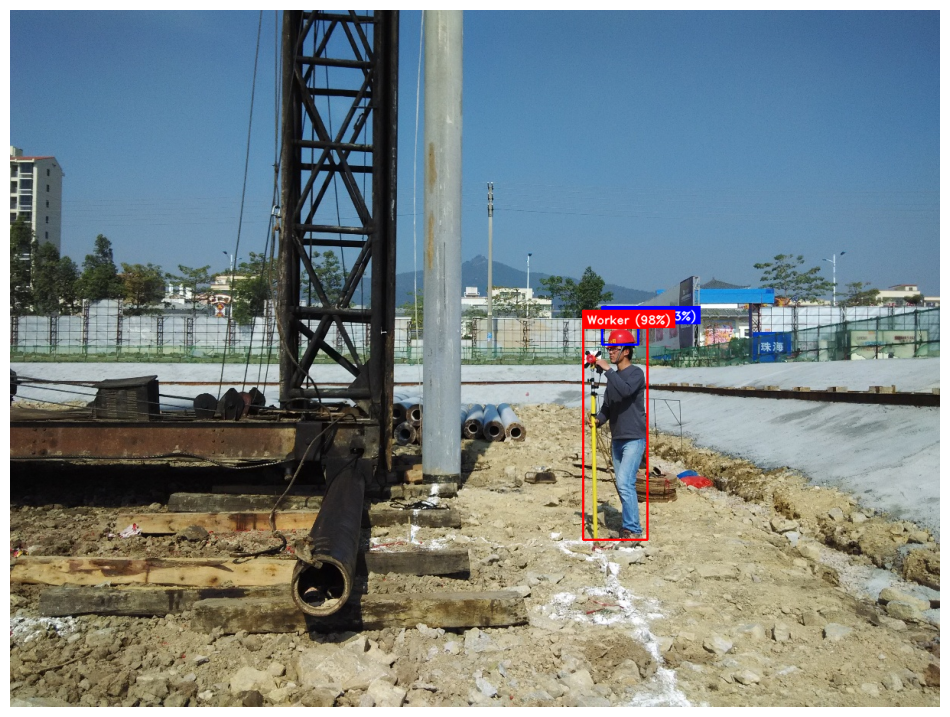

In [ ]:

from IPython.display import display, Math
from time import time

'''Get the image'''
image_data  = []
image_shape = []

act_img = cv2.imread( 'Images/image_from_china(2685).jpg')
image_shape.append( act_img.shape[:-1] )
image_data.append( letterbox_image(act_img, (416,416))/255. )

image_data  = np.array( image_data  )
image_shape = np.array( image_shape )

'''Get the boxes'''
t0 = time() # set a timer

prediction = model.predict(image_data)

boxes = detection(
    prediction,
    anchor_boxes,
    num_classes,
    image_shape,
    input_shape = (416,416),
    max_boxes = 10,
    score_threshold=0.3,
    iou_threshold=0.45)

print('time taken to process : {:.2f} ms'.format( (time()-t0)*1000 ))

'''Draw the boxes'''
detected_img = draw_detection(act_img, boxes[0].numpy(), class_names)

plt.figure(figsize=(12,12))
plt.imshow( detected_img[:,:,::-1] )
plt.axis('off')
plt.show()

In [ ]:
boxes

[<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
 array([[774.53, 411.33, 821.77, 438.67,   0.93,   0.  ],
        [749.63, 416.72, 833.43, 693.49,   0.98,   2.  ]], dtype=float32)>]

## Summary

In this lab we built a YOLO v3 model from scratch to predict only three classes and spent a lot of time on understanding the output format of YOLO. The anchor box concept is the key to the success of YOLO series: they are fast and flexible to various sizes and locations. The output formats also determine the loss function of the model and the performance evaluation.  

# Lab: Object Detection Performance Evaluation

Now we have predictions but do not know how good are those boxes. Performance evaluation of YOLO is essential to assess the accuracy and effectiveness of the object detection model.

The evaluation process is generally standarized with metrics like Intersection over Union (IoU), Precision, and Recall that can gauge the model's detection accuracy and its ability to generalize to new data, while also gaining insights into class-specific performance and error analysis.


## Objectives

* Evaluate the accuracy and effectiveness of the YOLO (You Only Look Once) object detection model.
* Use standardized metrics like Intersection over Union (IoU), Precision, and Recall to gauge the model's detection accuracy
* Understand the model ability to generalize to new data.

## Read Ground Truth

We first read all the images with bounding box labels. Save all boxes with the image names as keys. In this code, the format for each box is [class,x1,y1,x2,y2]. One image could have multiple boxes or zero box. Remember to clear output after look at the format. Uncomment the break to see different examples.


In [ ]:
PATH_LABELS='Labels/pictor_ppe_crowdsourced_approach-01_test.txt'
DIR_IMAGES='Images'

In [ ]:
import os

groundtruths = {}

with open(PATH_LABELS, 'r') as f:
    for line in f.readlines():
        # each line contains labels for each image
        print("ANNOTATION LINE:\n", line, '\n')
        gt_data = []
        # at each line, informaions are separated by a tab character ('\t')
        info = line.split("\t")

        # first piece of info is the file name of the image
        filename = info[0]
        print("IMAGE FILE NAME:", filename)

        # check if the image exists in the folder
        image_filepath = os.path.join(DIR_IMAGES, filename)
        if not os.path.exists(image_filepath):
            print("file not found:", image_filepath)
            break

        # read the image
        img = cv2.imread(image_filepath)

        # convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # next pieces of info are the boxes of
        for i, box in enumerate(info[1:]):

            print(f"BOX NO {i}:", box)

            # each box contains 5 values
            # x0, y0, x1, y1, c

            # split the information and convert to integer
            box_info_list = box.split(",")
            box_info = [int(x) for x in box_info_list]
            x0, y0, x1, y1, c = box_info

            # (x0,y0) is the top-left corner point
            # (x1,y1) is the bottom-right corner point
            # c is the class



            # choose some color to show different classes
            if c == 0:
                color = (255,0,0) #
            elif c == 1:
                color = (0,255,0) #
            elif c == 2:
                color = (0,0,255) #
            gt_data.append([c,x0, y0, x1, y1])

            # draw rectangle for each box
            img = cv2.rectangle(img, (x0,y0), (x1,y1), color, 2)
        groundtruths.update({filename:gt_data})
        # breaking the loop to show only one sample
        # break

In [ ]:
groundtruths['image_from_china(769).jpg']

[[2, 655, 524, 707, 719],
 [2, 630, 362, 676, 433],
 [2, 756, 348, 805, 416],
 [2, 356, 228, 382, 338],
 [0, 675, 525, 707, 552],
 [0, 356, 228, 374, 240],
 [2, 516, 246, 563, 326],
 [0, 645, 362, 662, 384],
 [0, 782, 348, 799, 365],
 [2, 77, 31, 104, 61],
 [2, 120, 23, 139, 55],
 [2, 416, 12, 426, 49],
 [2, 405, 23, 414, 37],
 [0, 90, 34, 98, 44],
 [0, 120, 23, 129, 32],
 [0, 407, 23, 412, 28],
 [0, 418, 12, 425, 19]]

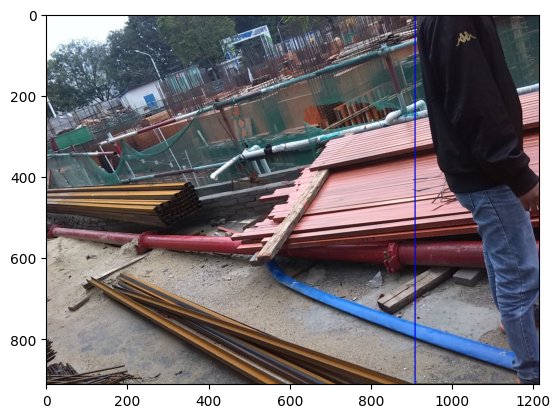

In [ ]:
plt.imshow(img)

## Save Predictions

It does not matter how you save the data as long as they keys match. This ensures the label boxes and prediction boxes will be compared for each image. Make prediction using the function made before and append the results using the same format. This will take some time. Switch the runtime type to GPU if you can and study the difference in processing speed.

In [ ]:
detections = {}

skipped_images = []

for img_name in list(groundtruths.keys()):

    image_data  = []
    image_shape = []

    act_img = cv2.imread( 'Images/'+img_name)
    image_shape.append( act_img.shape[:-1] )
    image_data.append( letterbox_image(act_img, (416,416))/255. )

    image_data  = np.array( image_data  )
    image_shape = np.array( image_shape )

    '''Get the boxes'''
    t0 = time() # set a timer

    prediction = model.predict(image_data)

    boxes = detection(
        prediction,
        anchor_boxes,
        num_classes,
        image_shape,
        input_shape = (416,416),
        max_boxes = 10,
        score_threshold=0.3,
        iou_threshold=0.45)
    results=[]
    for box in boxes[0].numpy():
        x1, y1, x2, y2 = box[:4].astype(int)
        score = box[-2]
        label = int(box[-1])
        results.append([label,x1, y1, x2, y2,score])
    detections.update({img_name : results})
    print("_{0}_".format(img_name),end="")
print("done")


1/1 [==============================] - 0s 30ms/step
_image_from_china(959).jpg_done


## Defined IoU function

For object detection tasks, the IoU is commonly used to determine whether a predicted bounding box is considered a true positive (correctly detected) or a false positive (incorrectly detected). If the IoU between the predicted bounding box and the ground truth bounding box exceeds a predefined threshold (often 0.5), the detection is considered correct.

In [ ]:
import numpy as np

def iou (boxes1, boxes2):
    '''
    boxes1: m x 4 numpy array
    boxes2: n x 4 numpy array
    '''
    boxes1 = np.array(boxes1, dtype='float32')
    boxes2 = np.array(boxes2, dtype='float32')

    m = boxes1.shape[0] # number of boxes1
    n = boxes2.shape[0] # number of boxes2

    boxes1_area = (boxes1[:,2]-boxes1[:,0])*(boxes1[:,3]-boxes1[:,1])
    boxes1_area = boxes1_area.repeat(n).reshape((m,n)) # converts to mxn matrix

    boxes2_area = (boxes2[:,2]-boxes2[:,0])*(boxes2[:,3]-boxes2[:,1])
    boxes2_area = np.tile(boxes2_area, (1,m)).reshape((m,n)) # converts to mxn matrix

    boxes1 = np.tile(boxes1, (1,n)).reshape((m,n,4))
    boxes2 = np.tile(boxes2, (m,1)).reshape((m,n,4))

    top = np.maximum(boxes1[:,:,:2],boxes2[:,:,:2])
    bot = np.minimum(boxes1[:,:,2:],boxes2[:,:,2:])

    diff = bot - top
    diff[diff<0] = 0
    intersection_area = diff[:,:,0] * diff[:,:,1]
    union_area = boxes1_area + boxes2_area - intersection_area

    # avoid division by zero
    idx = np.logical_or(boxes1_area==0, boxes2_area==0)
    union_area[idx] = 1

    return intersection_area/union_area

def is_TP (ious, iou_threshold=0.5):
    '''
    INPUT:
        m x n numpy array.
        - IoU between m detected boxes and n groud truth boxes
        - m detected boxes are sorted in descending order of confidence
    OUTPUT:
        m x 1 boolean array
        - indicates if corresponding detected box is true positve
    '''
    m, n = ious.shape

    result = np.zeros(m,dtype=bool) # to store the result

    for i in range(m):
        idx = np.argmax( ious[i,:] ) # index of the max iou
        if ious[i,idx] >= iou_threshold:
            result[i] = True
            ious[:,idx] = -1 # turn off the ground truth box that is already detected

    return result

## Check IoU on One Image

Here we can select one image key to get the `bx_gt` and `bx_dt` to calculate the IoU. This example has 5 predictions and 3 of them can be match more than 0.5 witht he ground truth label boxes.

In [ ]:
i='image_from_china(769).jpg'
x=2
bx_gt = np.array(groundtruths[i])
c_index=bx_gt[:,0] == x
bx_gt=bx_gt[c_index]

bx_dt = np.array(detections[i])
# if bx_dt.shape[0] == 0: continue
bx_dt = bx_dt[ bx_dt[:,0]==x,: ]

In [ ]:
ious = iou(bx_dt[:,1:5] , bx_gt[:,1:5] )
tps  = is_TP(ious)
print(ious,'\n',tps)

[[ 0.   -1.   -1.    0.   -1.    0.    0.    0.    0.  ]
 [ 0.   -1.   -1.    0.   -1.    0.    0.    0.    0.  ]
 [ 0.   -1.   -1.    0.   -1.    0.    0.    0.    0.  ]
 [ 0.   -1.   -1.    0.   -1.    0.46  0.    0.    0.  ]
 [ 0.   -1.   -1.    0.   -1.    0.    0.    0.    0.  ]] 
 [ True  True  True False False]


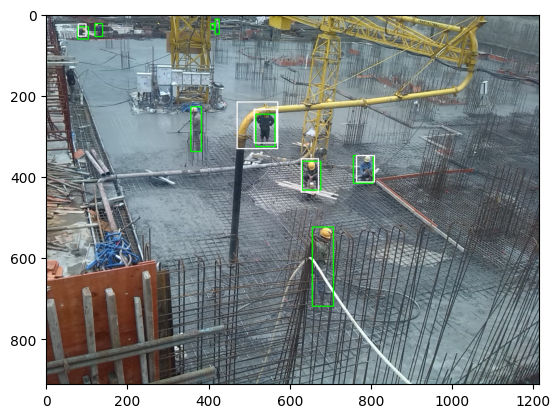

In [ ]:
img = cv2.imread('Images/'+i)

# convert BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for box in bx_gt:

    c ,x0, y0, x1, y1 = box

    img = cv2.rectangle(img, (x0,y0), (x1,y1), (0,255,0), 2)

for box in bx_dt:

    c ,x0, y0, x1, y1,p = box

    # draw rectangle for each box
    img = cv2.rectangle(img, (x0.astype(int),y0.astype(int)), (x1.astype(int),y1.astype(int)), (255,255,255), 2)

plt.imshow(img)

In the image above, we can see the ground truth boxes as green and detection boxes as white. We maticulously marked all the worker on the far side but the model does not detect all of them. This will descrease the performance calculation. Closer, one worker is blocked by the rebars and these will be False Negetive (FN) case becaues the model should detect them.  

In the middle of the crane, there is one large white box indicate the model thinks there is a worker but there is no ground truth box to match with it. This is a False Positve (FP) case.

## Precision and Recall

Now we can put everything together and make serveral variables to store the counts for precision recall calculation. Essentially, we want to keep track of True Postive (TP) cases where the prediction and ground truth boxes have more than 50% IoU.

$Precision = \frac{True Positives}{True Positives + False Positives}$

$Recall = \frac{True Positives}{True Positives + False Negatives}$


Note on the Evaluation Metrics:

* Precision: It is the ratio of true positive detections to the total number of detected bounding boxes at a given confidence threshold.
* Recall: It is the ratio of true positive detections to the total number of ground truth bounding boxes at a given confidence threshold.

* The function calculates the precision and recall for various confidence thresholds by sorting the detections based on confidence and iterating over them.
* The iou function is used to calculate the intersection over union (IoU) between bounding boxes, and is_TP function determines whether a detection is a true positive based on IoU thresholding.

In [ ]:

def evaluate (groundtruths, detections, included_class_names=class_names):
    '''
    groundtruths['image_name']:
        shape = (m, 1+4)
        [class_id, x0, y0, x1, y1]

    detections['image_name']  :
        shape=(n,1+4+1)
        [class_id, x0, y0, x1, y1, confidence]
    '''

    auc       = {c: 0 for c in included_class_names}
    precision = {c:[] for c in included_class_names}
    recall    = {c:[] for c in included_class_names}
    real_precision = {c:0 for c in included_class_names}
    real_recall    = {c:0 for c in included_class_names}

    for x,c in enumerate(included_class_names):
        detections_tps = np.array([])
        detections_confs = []
        num_gt = 0
        num_dt = 0
        for i in groundtruths:

            bx_gt = np.array(groundtruths[i])
            bx_gt = bx_gt[ bx_gt[:,0] == x,: ]
            num_gt += len(bx_gt)
            bx_dt = np.array(detections[i])
            if bx_dt.shape[0] == 0: continue
            bx_dt = bx_dt[ bx_dt[:,0]==x,: ]
            num_dt = num_dt + len(bx_dt)

            # print(bx_dt)

            if bx_gt.shape[0] != 0:

                ious = iou(bx_dt[:,1:5] , bx_gt[:,1:5] )
                tps  = is_TP(ious)
            else:
                tps = np.zeros(len(bx_dt))

            confs = bx_dt[:,-1]
            detections_tps = np.append(detections_tps,tps)
            detections_confs =  np.append(detections_confs,confs)

        # sort detection by confidence
        idc = np.argsort(detections_confs)[::-1]
        detections_tps = detections_tps[idc]

        num_tp = 0
        for i, tp in enumerate(detections_tps):
            if tp: num_tp += 1
            recall[c].append( num_tp/num_gt+0.000000000001 )
            precision[c].append( num_tp/(i+1) )


        for i in range(len(precision[c])):
            precision[c][i] = max(precision[c][i:])
        for i in range(1,len(precision[c])):
            auc[c] += precision[c][i] * ( recall[c][i]-recall[c][i-1] )

    # to make the graph close, nothing important here
    for c in included_class_names:
        recall[c].append(1.0)
        precision[c].append(0.0)

    real_auc=auc
    m_a_p = sum(real_auc.values())/len(real_auc)
    return m_a_p, real_auc, precision, recall

In [ ]:
m_a_p, real_auc, precision, recall=evaluate (groundtruths, detections, included_class_names=class_names)

In [ ]:
m_a_p

0.580272640078594

Plot the precision recall cases after sorting give the curve for each class. The area under this curve (AUC) is the average precision (AP) value and the mean AP across all classes is the mAP. We can see from this precision recall curve that class worker works better than others. Maybe the reason is the small size of the hardhat and vest.

In [ ]:
real_auc

{'Hardhat': 0.4691431290782858,
 'Vest': 0.5202380952380952,
 'Worker': 0.7514366959194012}

Text(0, 0.5, 'Precision')

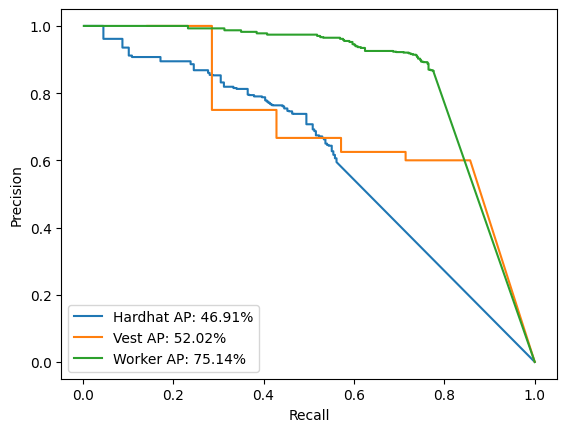

In [ ]:
for c in class_names:
    plt.plot(recall[c], precision[c],  linestyle='-',label=f"{c} AP: {real_auc[c]*100:.2f}%")
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')

## Summary

During this lab, we employed the annotated dataset to assess the performance of the YOLO model. The Intersection over Union (IoU) metric served as the foundation of the evaluation process. Using IoU, we identified the detection cases and computed the precision, recall, Average Precision (AP), and mean Average Precision (mAP) values to characterize the model's performance.

It is worth noting that most object detection evaluation metrics follow a similar pattern. Additionally, precision and recall values are influenced by the threshold chosen, and it is common practice to opt for a very low threshold (e.g., 0.01) when reporting the overall performance of the model.